# Playing Bandit Games

Code inspired by the [Pyma bandit library](https://www.di.ens.fr/~cappe/Code/PymaBandits/) by O. Cappé and A. Garivier and the [SMPyBandit library](https://github.com/SMPyBandits/SMPyBandits) of Lilian Besson.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time

# Bandit specific functions and classes (given) 
import Arms as arm
from StochasticBandit import *
from BanditTools import * 
import BanditBaselines as alg

# I) Getting started with simple strategies

## 1) Creating a bandit environment 

Different arm classes are defined in `Arms.py`. All arms can be sampled (i.e. produce random realization from their underlying distribution) using the "sample" method. 


In [2]:
arm1 = arm.Bernoulli(0.7)
print("The mean of arm 1 is",arm1.mean)
print("A sample from arm 1 is",arm1.sample(),"\n")

arm2 = arm.Gaussian(1,0.5)
print("The variance of arm 2 is",arm2.variance)
print("A sample from arm 2 is",arm2.sample())

The mean of arm 1 is 0.7
A sample from arm 1 is 1.0 

The variance of arm 2 is 0.5
A sample from arm 2 is 0.9656988129798268


To define a multi-armed bandit (a `MAB` object), you need to input a list of such arms. Some functions in `StochasticBandits.py` also define directly some particular MAB objects. MAB object have a method named generateReward that takes as an input and arm and generate a random reward from the underlying distribution. 

In [ ]:
bandit1 = MAB([arm.Bernoulli(0.2), arm.Gaussian(0.9, 1), arm.TruncatedExponential(2, 1)])
nbArms = bandit1.nbArms

bandit2 = BernoulliBandit([0.3, 0.4, 0.5])
# directly creates a Bernoulli bandit from a vector of means

print("The means of bandit instance 1 are", bandit1.means)
print("The means of bandit instance 2 are", bandit2.means)

print("Generated reward from arm 0 in bandit 2:", bandit2.generateReward(2))

The means of bandit instance 1 are [0.2, 0.9, 0.43233235838169365]
The means of bandit instance 2 are [0.3, 0.4, 0.5]
Generated reward from arm 0 in bandit 2: 0.0


## 2) Playing a bandit strategy 

In `BanditBaselines.py` you will find the two simplest examples of bandit strategy that we saw in class: the greedy strategy (Follow The Leader), which always selects the empirical best arm, and the Uniform strategy, which always selects an arm uniformly at random. A bandit strategy is a class that has two important methods: 
* self.chooseArmToPlay() : select the next arm to play 
* self.receiveReward(a,rew) : update the strategy when arm a was drawn and the reward rew was observed

I encourage you to keep the same structure for the smarter bandit strategies that you will implement in this notebook : specifying these two methods (and of course selecting the right attributes for the class). 

The following function can be used to run a given bandit strategy on some bandit instance. 

In [4]:
def OneBanditOneLearnerOneRun(bandit, strategy, timeHorizon):
    """
    Run a bandit strategy (strategy) on a MAB instance (bandit) for (timeHorizon) time steps
    output : sequence of arms chosen, sequence of rewards obtained
    """
    selections = []
    rewards = []
    strategy.clear() # reset previous history
    for t in range(timeHorizon):
        # choose the next arm to play with the bandit algorithm
        arm = strategy.chooseArmToPlay()
        # get the reward of the chosen arm
        reward = bandit.generateReward(arm)
        # update the algorithm with the observed reward
        strategy.receiveReward(arm, reward)
        # store what happened
        selections.append(arm)
        rewards.append(reward)
    return selections, rewards
    

We can use it to visualize what happens during a run of a bandit strategy, first what arms get selected. Don't hesitate to re-evaluate this cell multiple times, which will perform different random runs of the algorithm. You can also try to see what happens with the uniform strategy. 

In [5]:
def ViewSelections(selections):
    plt.clf()
    nbBins=max(selections) + 1
    plt.xlabel("Arms", fontsize=14)
    plt.ylabel("Number of arms selections", fontsize=14)
    plt.hist(selections, nbBins)
    plt.title("Number of selections of each arm", fontsize=14)
    axes=plt.gca()
    axes.xaxis.set_ticks(range(nbBins))

the means of the bandit are [0.3, 0.4, 0.5]
the average reward collected is 0.425


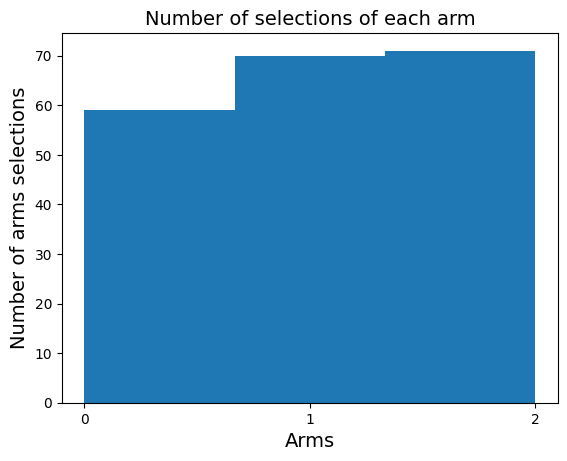

In [7]:
timeHorizon = 200
bandit = bandit2
nbArms = bandit.nbArms

strategy = alg.FTL(nbArms)
strategy = alg.UniformExploration(nbArms)

# generating a random trajectory of the bandit algorithm
selections, rewards = OneBanditOneLearnerOneRun(bandit, strategy, timeHorizon)

# compute average reward
print("the means of the bandit are",bandit.means)
print("the average reward collected is",np.sum(rewards)/timeHorizon)

# Histogram of the number of selections
ViewSelections(selections)

The (expected) cumulative regret of a strategy $\mathcal{A}=(A_t)_{t\in \mathbb{N}^*}$ is defined as $$\mathcal{R}_T(\mathcal{A}) = \mathbb{E}\left[\sum_{t=1}^{T} (\mu^\star - \mu_{A_t})\right].$$
The random quantity inside the expectation is the cumulative regret on one simulation (sometimes called pseudo-regret), ${R}_T(\mathcal{A}) = \sum_{t=1}^{T} (\mu^\star - \mu_{A_t})$. 

The function below returns a vector $({R}_t(\mathcal{A}))_{t \in [1,T]}$, giving the cumulative (pseudo)-regret in each time step. 

In [8]:
def CumulativeRegret(bandit,selections):
    """Compute the pseudo-regret associated to a sequence of arm selections"""
    T = len(selections)
    meansB = np.array(bandit.means)
    mustar = max(meansB)
    return np.cumsum(mustar*np.ones(T)-meansB[selections])

You can now visualize the regret as a function of time. Trying on different runs, you will see that the regret of FTL is either constant, or linear in $t$. Its expected regret will thus be linear.

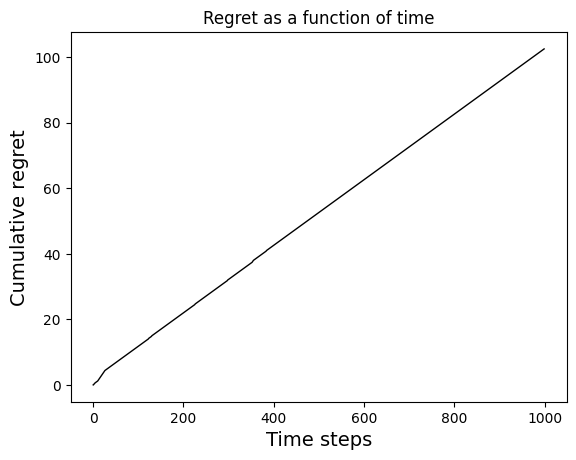

In [9]:
bandit = bandit2
timeHorizon = 1000
strategy = alg.FTL(nbArms)
selec, rewards = OneBanditOneLearnerOneRun(bandit, strategy, timeHorizon)
regret = CumulativeRegret(bandit, selec)

plt.figure(2)
plt.clf()
plt.xlabel("Time steps", fontsize=14)
plt.ylabel("Cumulative regret", fontsize=14)
plt.title("Regret as a function of time")
plt.plot(range(timeHorizon), regret, 'black', linewidth=1)
 

## 3) Comparison of two (bad) algorithm on multiple runs

The regret is defined as an **expectation**, so we need **several runs** to estimate its value. We can also take a look at empirical distribution of the pseudo-regret. The function below gathers results accross multiple runs.

In [10]:
def OneBanditOneLearnerMultipleRuns(bandit, strategy, timeHorizon, N_exp, tsave=[]):
    """
    Perform N_exp runs of a bandit strategy (strategy) on a MAB instance (bandit) for (timeHorizon) time steps 
    and compute the pseudo-regret of each run 
    optional : tsave is a vector of time steps in which the results will be stored (set to 1:timeHorizon by default)
    output : a table of size N_exp x |tsave| in which each row is the pseudo-regret at the sub-sampled times 
    """
    if (len(tsave) == 0):
        tsave = np.arange(timeHorizon)
    savedTimes = len(tsave)
    Regret = np.zeros((N_exp, savedTimes)) # Store the regret values on different runs
    for n in range(N_exp):
        np.random.seed()
        # run the bandit strategy
        selections, rewards = OneBanditOneLearnerOneRun(bandit, strategy, timeHorizon)
        # compute its pseudo-regret
        regret_one_run = CumulativeRegret(bandit, selections)
        # store (a sub-sampling of) the cumulative regret
        Regret[n, :] = np.array(regret_one_run)[tsave] 
    return Regret

In [11]:
bandit = MAB([arm.Bernoulli(0.2), arm.Bernoulli(0.5), arm.Gaussian(0.6, 0.25), arm.TruncatedExponential(1, 1)])
bandit.means
print(bandit.means)

algo1 = alg.FTL(bandit.nbArms)
algo2 = alg.UniformExploration(bandit.nbArms)


[0.2, 0.5, 0.6, 0.6321205588285577]


### a) For one algorithm (FTL)

In [12]:
N_exp = 200
timeHorizon = 500
tsave = np.arange(1, timeHorizon, 10) 
#print(tsave)
Regret = OneBanditOneLearnerMultipleRuns(bandit, algo1, timeHorizon, N_exp, tsave)

One can start by displaying the mean regret and some quantiles. 

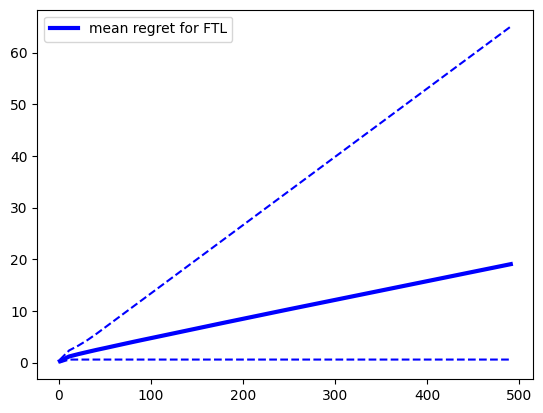

In [13]:
meanRegret = np.mean(Regret, 0)
upperQuantile = np.quantile(Regret, 0.95, 0) 
lowerQuantile = np.quantile(Regret, 0.05, 0)

plt.clf()
plt.plot(tsave, meanRegret, linewidth=3.0, color="b", label="mean regret for "+algo1.name())
plt.plot(tsave, upperQuantile, linestyle="dashed", color="b")
plt.plot(tsave, lowerQuantile, linestyle="dashed", color="b")
plt.legend()


#### b) FTL versus Uniform

In [14]:
def RunExpes(algorithms,bandit,N_exp,timeHorizon,step=10,quantiles = "on"):
    '''run experiments for multiple algorithms and display their regret on the same plot'''
    plt.clf()
    tsave = np.arange(1,timeHorizon,step)
    colors = ["b","r","g","k","m"]
    for i in range(len(algorithms)):
        algo=algorithms[i]
        Regret = OneBanditOneLearnerMultipleRuns(bandit, algo, timeHorizon, N_exp, tsave)
        plt.plot(tsave, np.mean(Regret, 0), linewidth=2.0, color=colors[i], label="mean regret of "+ algo.name())
        if (quantiles == "on"):
            plt.plot(tsave, np.quantile(Regret, 0.95, 0), tsave, np.quantile(Regret,0.05,0), linestyle="dashed", color=colors[i])
    plt.legend()
    plt.show()


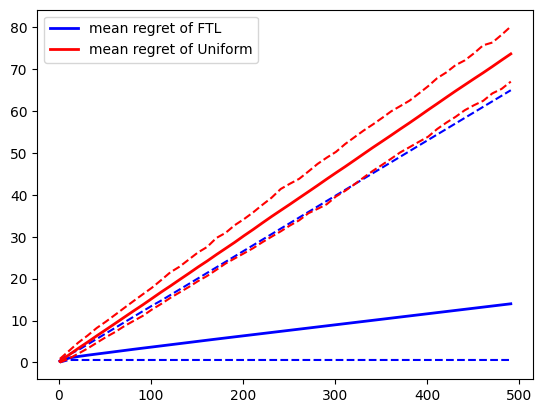

In [15]:
N_exp = 200
timeHorizon = 500
tsave = np.arange(1, timeHorizon, 10)

RunExpes([algo1,algo2],bandit,N_exp,timeHorizon,10,"on")

As you can see, both algorithms have **linear regret**. The regret of FTL is smaller than that of the Uniform strategy (on this instance), however its pseudo-regret has a much higher variance. 

# II) Implementing UCB


The UCB($\alpha$) algorithm that we saw in class selects in round $t$ the arm 
$$A_{t} = \underset{a}{\text{argmax}} \left[\hat{\mu}_a(t-1) + \sqrt{\frac{\alpha \log(t)}{N_a(t-1)}}\right],$$
where $\hat{\mu}_a(t)$ is the empirical mean of arm $a$ after $t$ rounds and $N_a(t)$ is the number of selections of arm $a$ till that time. 

**Complete the code below**

In [18]:
class UCB:
    """UCB1 with parameter alpha"""
    def __init__(self, nbArms, alpha=1/2):
        self.nbArms = nbArms
        self.alpha = alpha
        self.clear()

    def clear(self):
        self.nbDraws = np.zeros(self.nbArms)
        self.cumRewards = np.zeros(self.nbArms)
        self.t = 0
    
    def chooseArmToPlay(self):
        ## TO BE COMPLETED
        if self.t < self.nbArms:
            arm = self.t
        else:
            arm = np.argmax(self.cumRewards/self.nbDraws + np.sqrt(self.alpha*np.log(self.t)/(2*self.nbDraws)))
        return arm

    def receiveReward(self, arm, reward):
        self.t = self.t + 1
        self.nbDraws[arm] = self.nbDraws[arm] + 1
        self.cumRewards[arm] = self.cumRewards[arm] + reward

    def name(self):
        return "UCB"

Observe that UCB with $\alpha = 0$ coincides with Follow the Leader and has therefore linear regret, whereas $\alpha = 1/2$ is a robust choice that guarantees logarithmic regret on every bandit instance with bounded rewards. Still, on a particular instance it is possible to find a value of $\alpha$ that leads to better performance compared to $\alpha = 1/2$ (but it will not work on *any* problem instance). 

The means in this bounded instance are [0.3, 0.6, 0.8, 0.7191638517265578]


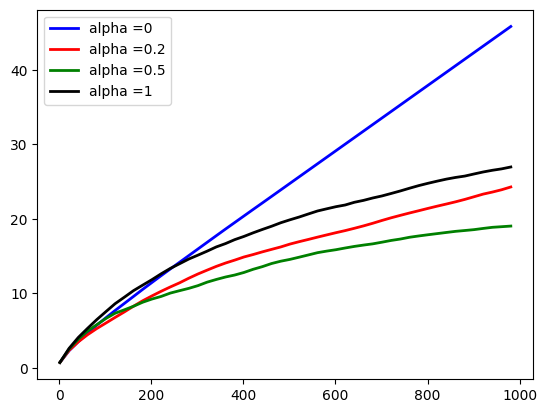

In [19]:
bandit = MAB([arm.Bernoulli(0.3), arm.Bernoulli(0.6), arm.Bernoulli(0.8), arm.TruncatedExponential(0.7, 1)])
print("The means in this bounded instance are", bandit.means)

alphas = [0,0.2,0.5,1] # choose your values of alpha
algos = [UCB(4, alpha) for alpha in alphas]
colors = ["b", "r", "g", "k", "c", "m"]

nbAlgos = len(alphas)

N_exp = 100
timeHorizon = 1000
tsave = np.arange(1, timeHorizon, 20)

for i in range(nbAlgos):
    alpha = alphas[i]
    learner = algos[i]
    Regret = OneBanditOneLearnerMultipleRuns(bandit, learner, timeHorizon, N_exp, tsave)
    plt.plot(tsave, np.mean(Regret,0), linewidth=2.0, color=colors[i], label="alpha ="+str(alpha))
   
plt.legend()
plt.show()


# III) UCB versus Thompson Sampling 

For Bernoulli bandit, we saw in class that UCB is not optimal, and the goal of this part is to compare it to Thompson Sampling, which is a Bayesian algorithm with better theoretical guarantees. 

Letting $\pi_a(t)$ denote the posterior distribution on arm $a$ after $t$ rounds, Thompson Sampling can be implemented as follows: 

$$\forall a, \theta_a(t) \sim \pi_a(t-1), \ \ \ A_{t} = \underset{a}{\text{argmax }} \theta_a(t)$$

In the Bernoulli case, with a uniform (or more generally a Beta $(\alpha,\beta)$) prior distribution on each mean, the posterior distribution remains a Beta distribution. More precisely, one has

$$\pi_a(t) = \mathrm{Beta}\left(\alpha + S_a(t), \beta + N_a(t) - S_a(t)\right),$$

where $S_a(t)$ is the sum of rewards received from arm $a$ after $t$ rounds, and $N_a(t)$ is the number of selections of that arm, as before.

**Complete the code below.** 


In [28]:
class ThompsonSampling:
    """Thompson Sampling with Beta(a,b) prior and Bernoulli likelihood"""
    def __init__(self, nbArms, a=1, b=1):
        self.nbArms = nbArms
        self.a = a
        self.b = b
        self.clear()

    def clear(self):
        self.nbDraws = np.zeros(self.nbArms)
        self.cumRewards = np.zeros(self.nbArms)
    
    def chooseArmToPlay(self):
        ## TO BE COMPLETED
        alpha = self.a + self.cumRewards
        beta = self.b + self.nbDraws
        theta = np.random.beta(alpha,beta)
        arm = np.argmax(theta)
        return arm

    def receiveReward(self, arm, reward):
        self.nbDraws[arm] = self.nbDraws[arm] + 1
        self.cumRewards[arm] = self.cumRewards[arm] + reward

    def name(self):
        return "Thompson Sampling"

**Compare the regret of UCB and Thompson Sampling on the following two bandit instances**

In the first bandit, the means are all close to $1/2$, whereas in the second the means are all very low, which corresponds to what typically happens in applications to online advertisement. Comment on the results. 

In [32]:
banditA = BernoulliBandit([0.45, 0.5, 0.6])  
banditB = BernoulliBandit([0.1, 0.05, 0.02, 0.01])

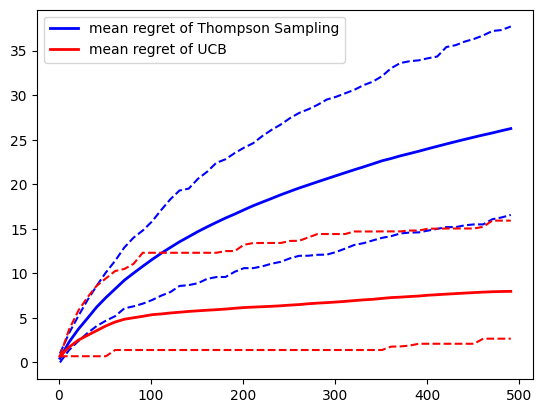

In [35]:
N_exp = 200
timeHorizon = 500
tsave = np.arange(1, timeHorizon, 10)

algo1 = ThompsonSampling(banditA.nbArms)
algo2 = UCB(banditA.nbArms, 1/2)

RunExpes([algo1,algo2],bandit,N_exp,timeHorizon,10,"on")

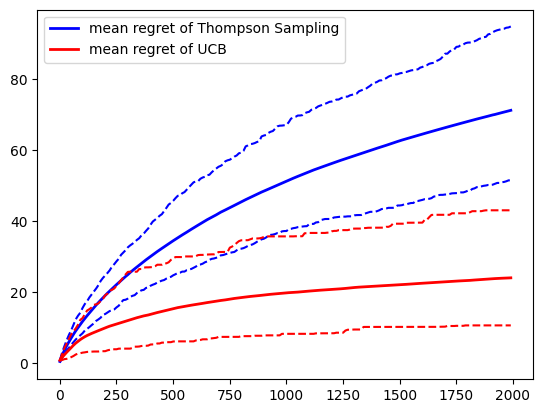

In [37]:
N_exp = 200
timeHorizon = 2000
tsave = np.arange(1, timeHorizon, 10)

algo1 = ThompsonSampling(banditB.nbArms)
algo2 = UCB(banditB.nbArms, 1/2)

RunExpes([algo1,algo2],bandit,N_exp,timeHorizon,10,"on")